In [1]:
import autograd.numpy as np
from autograd.scipy.special import logsumexp,erf
from autograd.scipy.stats import norm
from autograd import grad

#from autograd_gamma import gamma, gammainc, gammaincc, gammaincln, gammainccln

import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import product
from itertools import combinations
import pickle

from io import StringIO
from Bio import Phylo

from tree import Tree
from optimizer import Optimizer

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

/Users/evsi8432/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pop_size = 5.0 # exponential parameter for constant pop size prior
data_file = '../dat/DS1/DS1.pickle'

In [3]:
with open(data_file, 'rb') as f:
    DS1 = pickle.load(f)

In [4]:
genomes = []
species = []
for key in DS1:
    genomes.append(DS1[key])
    species.append(key)
    
n_species = len(species)

In [5]:
n_species = 3
genome_size = 100
genomes = ['']*n_species
ps = [[0.9,0.01,0,0,0.09],
      [0.9,0.1,0,0,0.0],
      [0.9,0.1,0,0,0.0]]
for _ in range(genome_size):
    for s in range(n_species):
        genomes[s] += np.random.choice(['A','T','G','C','-'],p=ps[s])
        
#genomes = [["A"],["T"],["C"]]

In [6]:
# From https://github.com/zcrabbit/vbpi-torch/blob/ff86cf0c47a5753f5cc5b4dfe0b6ed783ab22669/unrooted/phyloModel.py#L7-L11
nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.]}

tree_log_probs = np.array([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = float)
tree_log_probs = np.log(tree_log_probs)

# Set initial $\theta$ randomly

In [7]:
theta = np.zeros((2,n_species,n_species))

theta[0] = np.random.normal(size = (n_species,n_species)) + np.log(pop_size)
theta[0] = theta[0]*np.tril(np.ones((n_species,n_species)),k=-1)
theta[1] = 0.01*np.random.normal(size = (n_species,n_species))
theta[1] = theta[1]*np.tril(np.ones((n_species,n_species)),k=-1)

print(theta.shape)

(2, 3, 3)


In [8]:
Z = np.random.normal(np.ones_like(theta[0]))
log_times = np.exp(theta[1])*Z+theta[0]
log_times = log_times + np.triu(np.ones_like(theta[0])*np.inf)

tree = Tree(theta,log_times,tree_log_probs,
            pop_size=pop_size)

print(tree.log_like)
print(tree.log_prior)
print(tree.log_q)

-400.63907036363946
-10.493896358093473
-9.66147653508776


# Do Variational Inference

In [9]:
genomes

['AAAAAAAAA-AAAAAAAAAAAAAA-AAAAAAAAAAAAAAAAAAAAAAAA-AAAAAAAAA-AAAAAAAAAA-AAAA--AAAAAAAAA-AAA---AAAAAAA',
 'AAAATAAAAAAAAAAAATAAAAATAAAAAAAAAATATAAAAAAAAAAAAAAAAAAAAAAAATAATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAT',
 'AATAAATAAAAATAAAAAAAAAAAAAAAATAAAAAAAAAATAAAAAAAATAAAATAAAAAAAAAAAAAAAAAAAAAAAAAAAATTAATAAATAAAAAAAT']

0.0
runtime:  0:00:00.967594
[[[  0.           0.           0.        ]
  [ -5.93595129   0.           0.        ]
  [ -9.05187621  -1.1379927    0.        ]]

 [[  0.           0.           0.        ]
  [ -8.56721224   0.           0.        ]
  [-10.68097937 -18.65031342   0.        ]]]
[[[ 0.          0.          0.        ]
  [-0.60791522  0.          0.        ]
  [-0.88482934  0.21831718  0.        ]]

 [[ 0.          0.          0.        ]
  [ 1.14123457  0.          0.        ]
  [ 0.97576366  1.22255004  0.        ]]]

0.1
runtime:  0:00:09.405364
[[[  0.           0.           0.        ]
  [-12.97038184   0.           0.        ]
  [ -9.40265609  -4.12136266   0.        ]]

 [[  0.           0.           0.        ]
  [ -6.97224996   0.           0.        ]
  [ -8.5600203   -4.21658468   0.        ]]]
[[[ 0.          0.          0.        ]
  [-1.60254671  0.          0.        ]
  [-1.88950343 -0.72864392  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.21505

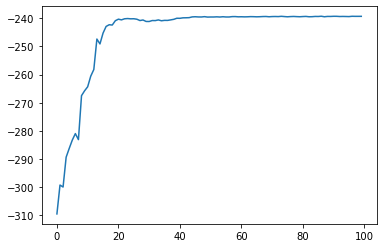

In [17]:
optim_reparam = Optimizer(tree_log_probs,deepcopy(theta))

optim_reparam.optimize_q_reparam(100,100,alphas=[0.1,0.1],
                          print_out=True,pop_size=pop_size)

print("final theta:",optim_reparam.theta)
plt.plot(optim_reparam.ELBO_ests)

0.0
runtime:  0:00:02.634245
grad_theta:  [[[ 0.          0.          0.        ]
  [ 0.08039282  0.          0.        ]
  [-0.07113576 -0.05242369  0.        ]]

 [[ 0.          0.          0.        ]
  [-0.12131775  0.          0.        ]
  [ 0.08828033  0.01923106  0.        ]]]
theta:  [[[ 0.          0.          0.        ]
  [-2.65094575  0.          0.        ]
  [-2.58451065 -1.6707821   0.        ]]

 [[ 0.          0.          0.        ]
  [-1.05823501  0.          0.        ]
  [-1.1494427  -0.88510128  0.        ]]]

0.1
runtime:  0:00:30.460358
grad_theta:  [[[ 0.          0.          0.        ]
  [ 0.08631412  0.          0.        ]
  [ 0.21099689 -0.05167871  0.        ]]

 [[ 0.          0.          0.        ]
  [-0.04722042  0.          0.        ]
  [ 0.00767959 -0.01734673  0.        ]]]
theta:  [[[ 0.          0.          0.        ]
  [-2.73875987  0.          0.        ]
  [-2.49813657 -1.96804204  0.        ]]

 [[ 0.          0.          0.        ]
  [-0

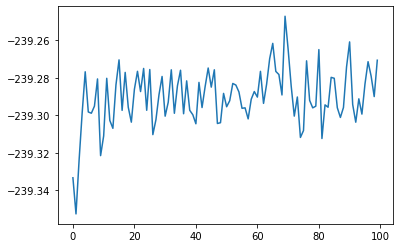

In [40]:
optim_reinforce = Optimizer(tree_log_probs,deepcopy(optim_reparam.theta))

optim_reinforce.optimize_q_reinforce(1000,100,alphas=[0.1,0.01],
                                      print_out=True,pop_size=pop_size)

print("final theta:",optim_reinforce.theta)
plt.plot(optim_reinforce.ELBO_ests)

0.0
runtime:  0:00:00.307763
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 3.49261136e-03  0.00000000e+00  0.00000000e+00]
  [-8.39524245e-03 -5.65876149e-06  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 6.17807544e-04  0.00000000e+00  0.00000000e+00]
  [ 3.60486688e-03 -9.26784170e-05  0.00000000e+00]]]
[[[ 0.          0.          0.        ]
  [-2.65094849  0.          0.        ]
  [-2.5845096  -1.6690458   0.        ]]

 [[ 0.          0.          0.        ]
  [-0.85825127  0.          0.        ]
  [-1.14944536 -1.08499298  0.        ]]]

0.1
runtime:  0:00:02.829658
[[[ 0.          0.          0.        ]
  [ 0.00025746  0.          0.        ]
  [-0.00091679  0.00133683  0.        ]]

 [[ 0.          0.          0.        ]
  [-0.00123671  0.          0.        ]
  [ 0.00270034 -0.00073926  0.        ]]]
[[[ 0.          0.          0.        ]
  [-2.65554201  0.          0.        ]
  [-2.48693334 -2.05459436  0.        ]]

 [[ 0.         

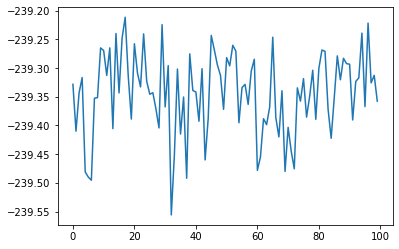

In [21]:
optim_VIMCO = Optimizer(tree_log_probs,deepcopy(optim_reparam.theta))

optim_VIMCO.optimize_q_VIMCO(100,100,alphas=[0.1,0.1],
                       print_out=True,pop_size=pop_size)
#optim.optimize_q_reinforce(5,1000,alphas=[0.01,0.01],
#                           pop_size=np.ones_like(theta[0]))

print("final theta:",optim_VIMCO.theta)
plt.plot(optim_VIMCO.ELBO_ests)

In [41]:
print(optim_reparam.ELBO_ests[-1])
print(optim_reinforce.ELBO_ests[-1])
print(optim_VIMCO.ELBO_ests[-1])

-239.26898654748004
-239.27067374780964
-239.3575460097094


# Print out a random tree

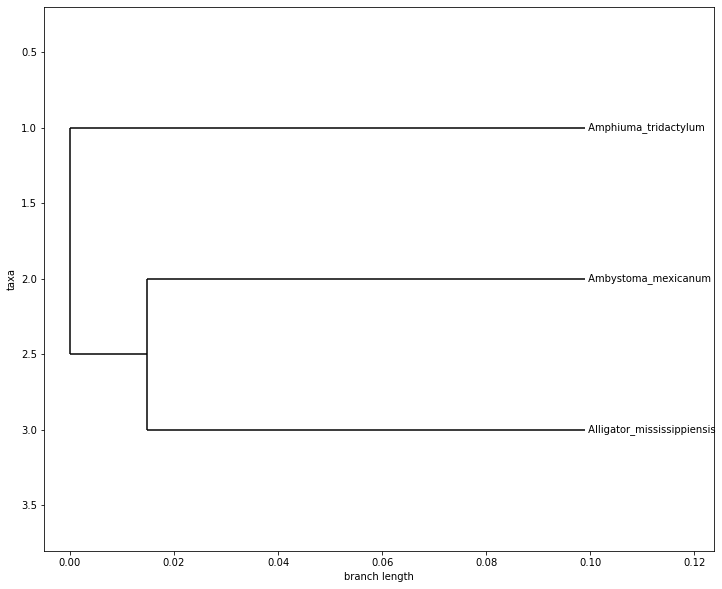

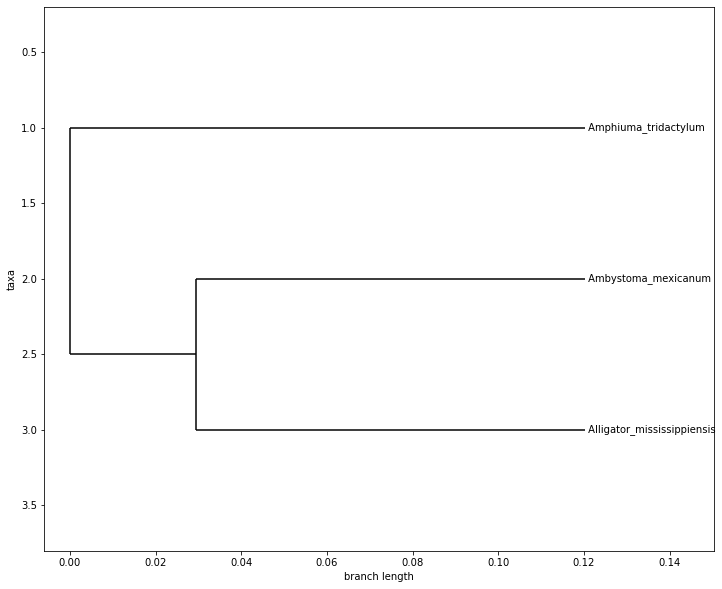

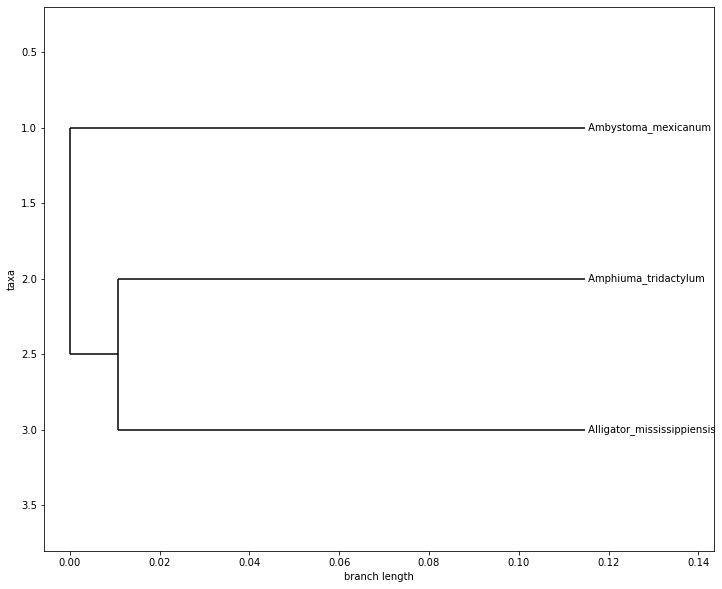

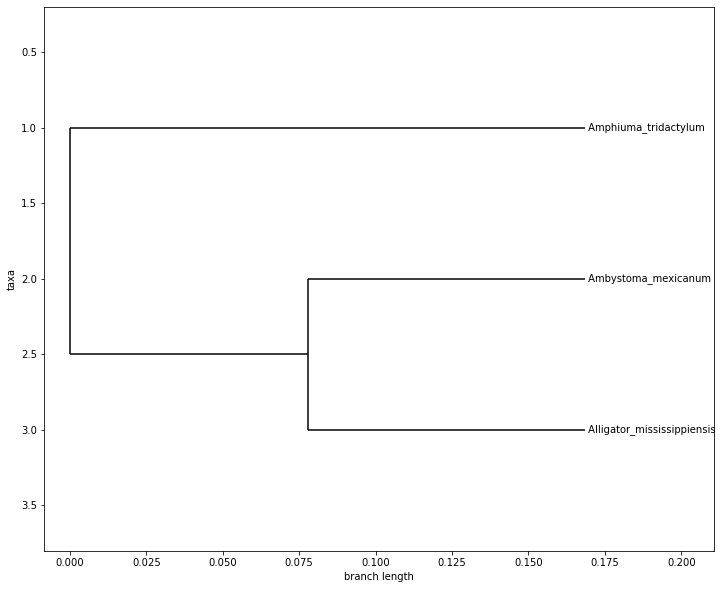

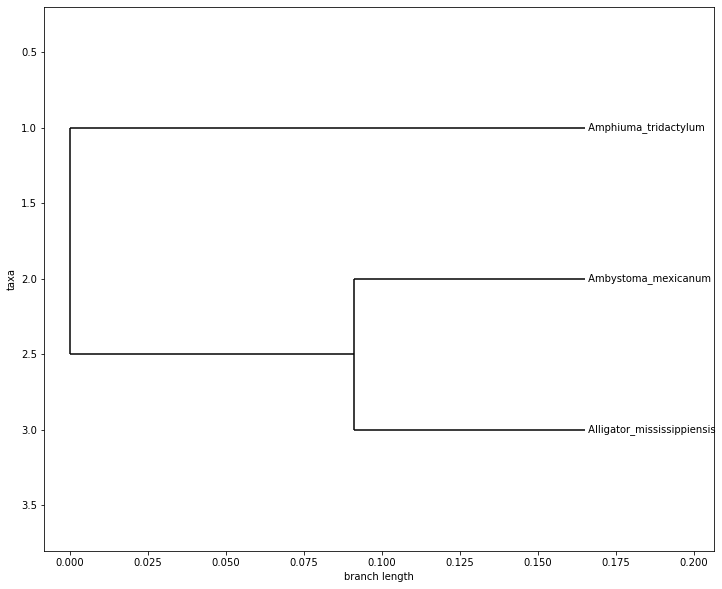

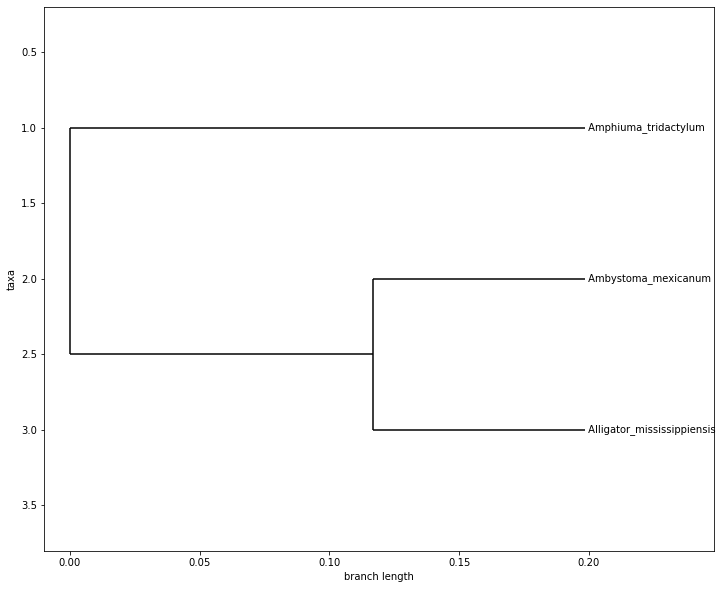

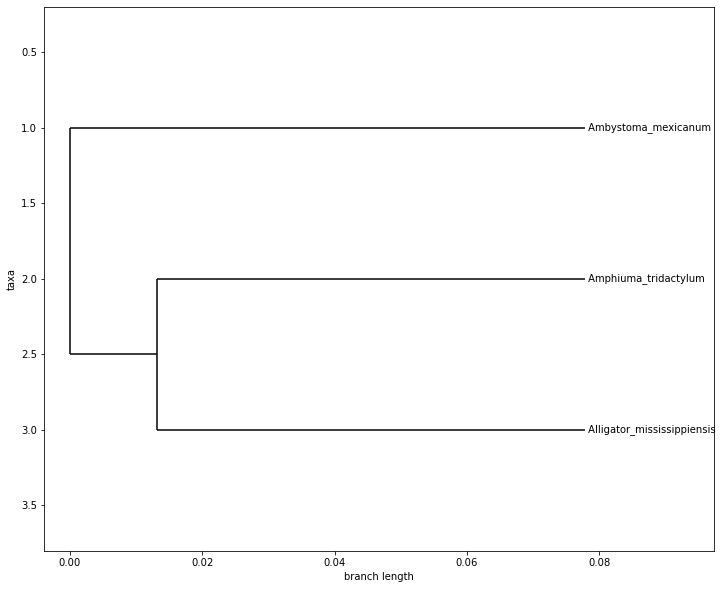

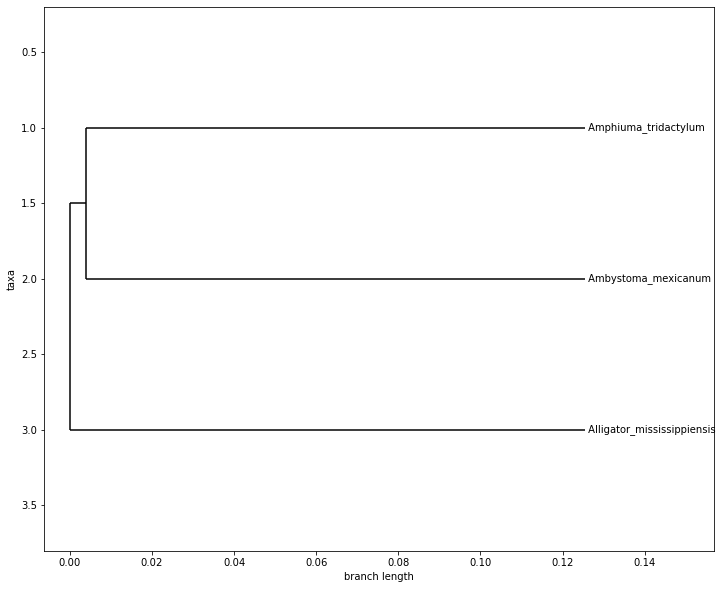

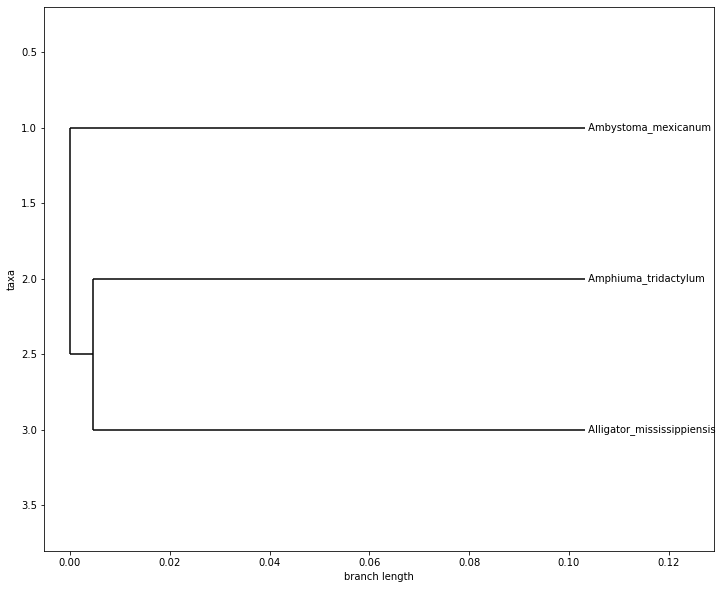

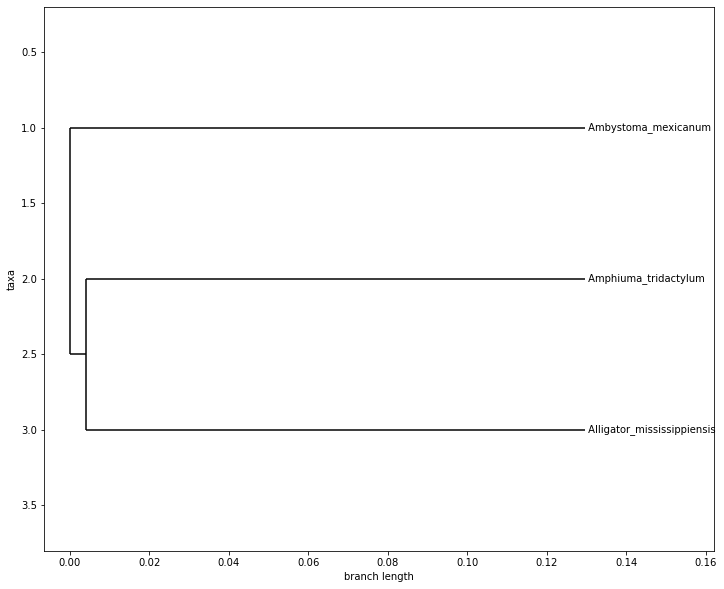

In [42]:
def write_newick(node):
    
    if node.children == []:
        return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time)
    elif node.parent is None:
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
    else:
        bl = node.parent.coal_time - node.coal_time
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)

    
for _ in range(10):
    Z = np.random.normal(np.ones_like(theta[0]))
    log_times = np.exp(theta[1])*Z+theta[0]
    log_times = log_times + np.triu(np.ones_like(theta[0])*np.inf)

    tree = Tree(theta,log_times,tree_log_probs,
                pop_size=pop_size)


    treedata = write_newick(tree.nodes[-1])
    handle = StringIO(treedata)
    tree_to_draw = Phylo.read(handle, "newick")

    # Set up the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Draw the phylogenetic tree
    Phylo.draw(tree_to_draw, axes=ax)
    fig.show()

# Estimate the marginal likelihood

In [43]:
optim = optim_reinforce
theta = optim.theta

In [44]:
tree = Tree(optim.theta,log_times,
            deepcopy(tree_log_probs),
            pop_size=pop_size)

In [45]:
n_exp = 100
n_samples = 100

priors = np.zeros(n_exp)
LL = np.zeros(n_exp)
MLL_all = np.zeros(n_exp)
ELBO_all = np.zeros(n_exp) 

for i in range(n_exp):

    MLL = np.zeros(n_samples)
    ELBO = np.zeros(n_samples)
    
    Zs = np.random.normal(size=(n_samples,n_species,n_species))

    for j,Z in enumerate(Zs):
        log_times = np.exp(theta[1])*Z+theta[0]
        log_times = log_times + np.triu(np.full(n_species, np.inf))
        tree = Tree(optim.theta,log_times,
                    deepcopy(tree_log_probs),
                    pop_size=pop_size)
        
        MLL[j] = tree.log_p - tree.log_q
        ELBO[j] = tree.log_p - tree.log_q
    
    priors[i] = tree.log_prior
    LL[i] = tree.log_like
    MLL_all[i] = logsumexp(MLL) - np.log(n_samples)
    ELBO_all[i] = np.mean(ELBO)

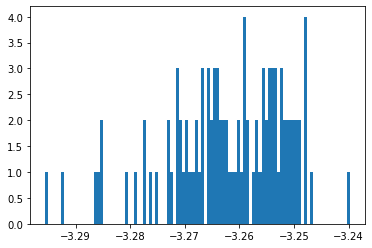

In [46]:
plt.hist(priors,bins = 100)
plt.show()

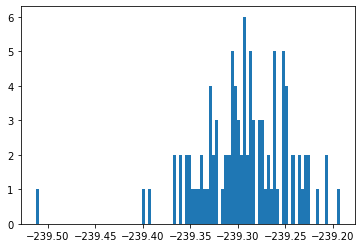

In [47]:
plt.hist(ELBO_all,bins = 100)
plt.show()

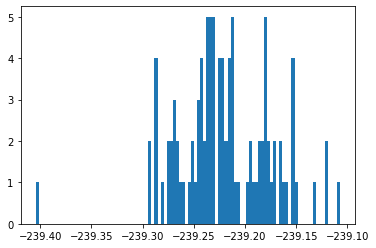

In [48]:
plt.hist(MLL_all,bins = 100)
plt.show()

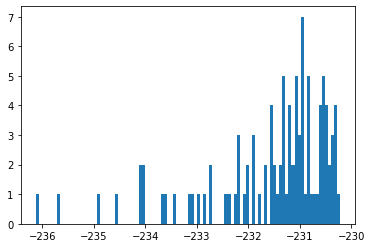

In [49]:
plt.hist(LL,bins = 100)
plt.show()

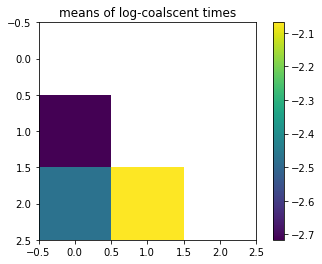

In [50]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()

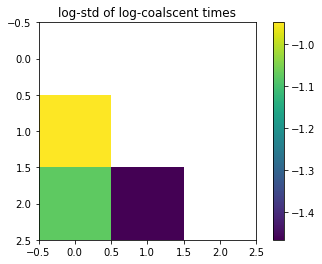

In [51]:
log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

# Plot the likelihood surface for 3-taxa trees

In [52]:
def plot_q(theta,res):
    # select t lims from sampling 1000 trees
    min_time = np.min((-5*np.exp(theta[1])+theta[0])[np.tril(np.full((n_species), True),k=-1)])
    max_time = np.max(( 3*np.exp(theta[1])+theta[0])[np.tril(np.full((n_species), True),k=-1)])
    tlims = [min_time,max_time]

    #print(theta)
    log_p = np.zeros((3,res,res))
    log_q = np.zeros((3,res,res))
    ELBO = np.zeros((3,res,res))

    orders = [[0,1,2],[0,2,1],[1,2,0]]
    tau_labels = ['(({A},{B}),({A,B},{C}))',
                  '(({A},{C}),({A,C},{B}))',
                  '(({B},{C}),({A},{B,C})']

    for k,inds in enumerate(orders):

        time1s = np.linspace(tlims[0],tlims[1],res)
        time2s = np.linspace(tlims[0],tlims[1],res)

        for i,time1 in enumerate(time1s):
            for j,time2 in enumerate(time2s):

                if time1 > time2:
                    log_p[k,j,i] = -np.inf
                    log_q[k,j,i] = -np.inf

                else:
                    times = np.inf*np.ones((3,3))

                    inds1 = [inds[x] for x in [0,1]]
                    inds2 = [inds[x] for x in [0,2]]
                    inds3 = [inds[x] for x in [1,2]]

                    times[max(inds1),min(inds1)] = time1
                    times[max(inds2),min(inds2)] = time2
                    times[max(inds3),min(inds3)] = time2+1

                    tree = Tree(theta,times,tree_log_probs,
                                pop_size=pop_size)

                    log_p[k,j,i] = tree.log_p
                    log_q[k,j,i] = tree.log_q
                    ELBO[k,j,i] = np.exp(tree.log_q)*(tree.log_p - tree.log_q)
    log_p = log_p-logsumexp(log_p[~np.isnan(log_p)])+logsumexp(log_q[~np.isnan(log_q)])
    vmax = np.nanmax([log_p,log_q])

    i = 0
    plt.subplots(figsize = (20,12))
    for k in range(3):

        i += 1
        plt.subplot(3,3,i)

        plt.imshow(log_p[k], interpolation='nearest', origin='lower',
                   extent=[tlims[0],tlims[1],tlims[0],tlims[1]],vmin=vmax-6,vmax=vmax)
        plt.xlabel(r'$\log(t_1)$',fontsize = 16)
        plt.ylabel(r'$\log(t_2)$',fontsize = 16)
        plt.title(r'log(p), $\tau$ = %s' % tau_labels[k],fontsize = 16)
        plt.colorbar()

        plt.subplot(3,3,i+3)

        plt.imshow(log_q[k], interpolation='nearest', origin='lower',
                   extent=[tlims[0],tlims[1],tlims[0],tlims[1]],vmin=vmax-6,vmax=vmax)
        plt.xlabel(r'$\log(t_1)$',fontsize = 16)
        plt.ylabel(r'$\log(t_2)$',fontsize = 16)
        plt.title(r'log(q), $\tau$ = %s' % tau_labels[k],fontsize = 16)
        plt.colorbar()

    plt.show()
    return

REINFORCE:


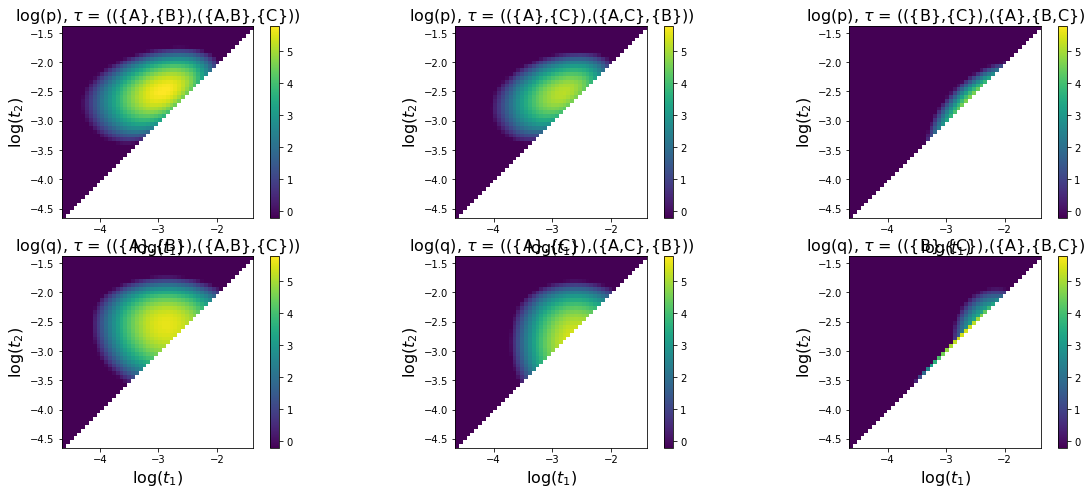

VIMCO:


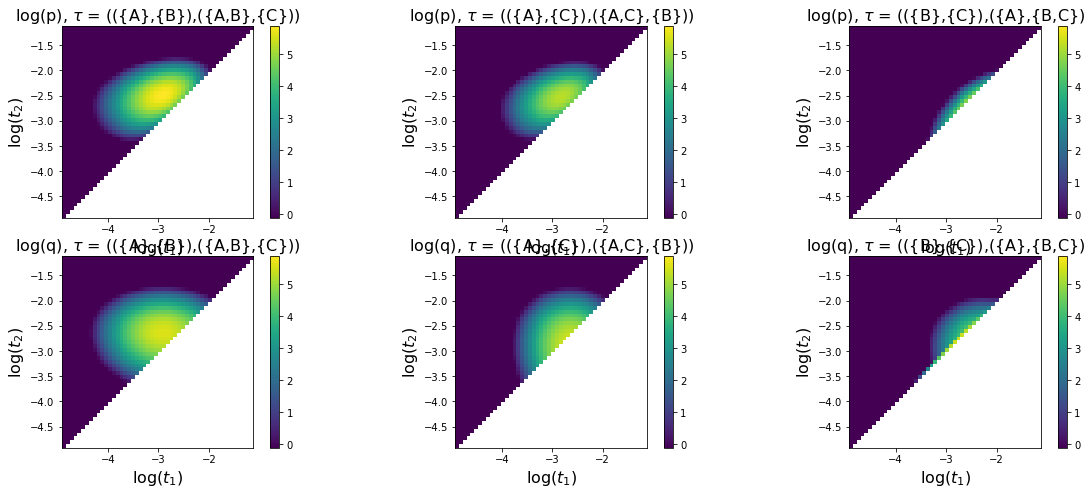

Reparam:


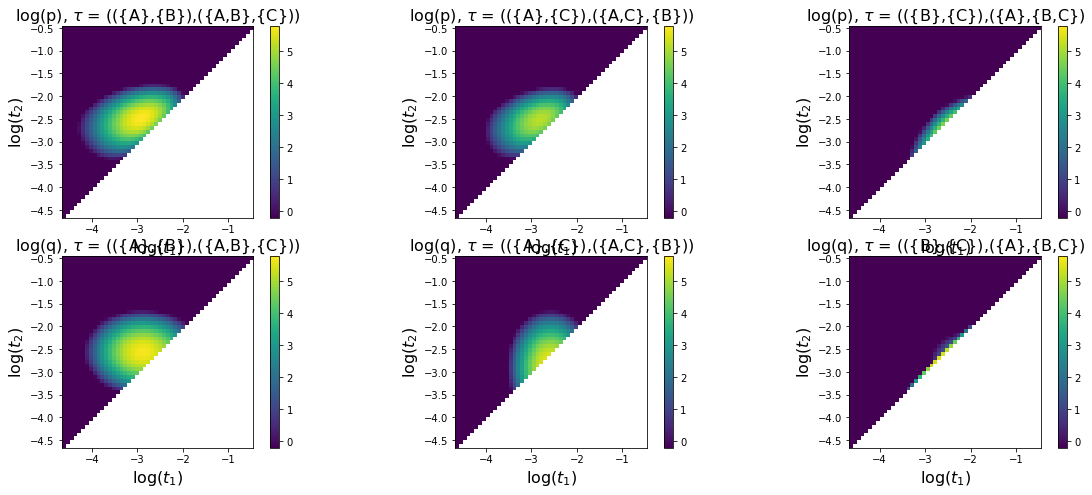

In [53]:
print("REINFORCE:")
plot_q(optim_reinforce.theta,res=50)
print("VIMCO:")
plot_q(optim_VIMCO.theta,res=50)
print("Reparam:")
plot_q(optim_reparam.theta,res=50)

# Visualize the boundary

In [ ]:
theta = optim.theta
res = 500

# select t lims from sampling 1000 trees
Z1 = 0
min_time = np.min((-5*np.exp(theta[1])+theta[0])[np.tril(np.full((n_species), True),k=-1)])
max_time = np.max(( 3*np.exp(theta[1])+theta[0])[np.tril(np.full((n_species), True),k=-1)])
tlims = [min_time,max_time]

#print(theta)
log_p = np.zeros((3,res))
log_q = np.zeros((3,res))
ELBO = np.zeros((3,res))

eps = 0.00001

orders = [[0,1,2],[0,2,1],[1,2,0]]
tau_labels = ['(({A},{B}),({A,B},{C}))',
              '(({A},{C}),({A,C},{B}))',
              '(({B},{C}),({A},{B,C})']

for k,inds in enumerate(orders):
    
    time1s = np.linspace(tlims[0],tlims[1],res)
    
    for i,time1 in enumerate(time1s):
        
        time2 = time1 + eps
                
        times = np.inf*np.ones((3,3))

        inds1 = [inds[x] for x in [0,1]]
        inds2 = [inds[x] for x in [0,2]]
        inds3 = [inds[x] for x in [1,2]]

        times[max(inds1),min(inds1)] = time1
        times[max(inds2),min(inds2)] = time2
        times[max(inds3),min(inds3)] = time2+1

        tree = Tree(theta,times,tree_log_probs,
                    pop_size=pop_size)

        log_p[k,i] = tree.log_p
        log_q[k,i] = tree.log_q
        ELBO[k,i] = np.exp(tree.log_q)*(tree.log_p - tree.log_q)

In [ ]:
np.max(np.exp(log_q.T))

In [ ]:
plt.plot(time1s,np.exp(log_q.T)*(log_p.T-log_q.T))
plt.show()

In [ ]:
plt.plot(time1s,log_q.T,'-.')
plt.show()

In [ ]:
theta = optim.theta
res = 200

# select t lims from sampling 1000 trees
Z1 = -3
Z2s = np.linspace(-5,5,res)
Z3s = np.linspace(-5,5,res)
tlims = [-5,5]

#print(theta)
log_p = np.zeros((res,res))
log_q = np.zeros((res,res))
ELBO = np.zeros((res,res))
    
for i,Z2 in enumerate(Z2s):
    for j,Z3 in enumerate(Z3s):

        Z = np.array([[np.inf,np.inf,np.inf],
                      [Z2    ,np.inf,np.inf],
                      [Z3    ,Z1   ,np.inf]])

        log_times = np.exp(theta[1])*Z+theta[0]

        tree = Tree(theta,log_times,tree_log_probs,
                    pop_size=pop_size)

        log_p[j,i] = tree.log_p
        log_q[j,i] = tree.log_q
        ELBO[j,i] = (tree.log_p-tree.log_q)


In [ ]:
#log_p = log_p-logsumexp(log_p[~np.isnan(log_p)])+logsumexp(log_q[~np.isnan(log_q)])
vmaxp = np.nanmax([log_p])
vmaxq = np.nanmax([log_q])
plt.subplots(figsize = (20,12))
    
plt.subplot(1,3,1)

plt.imshow(log_p, interpolation='nearest', origin='lower',
           extent=[tlims[0],tlims[1],tlims[0],tlims[1]],vmin=vmaxp-6,vmax=vmaxp)
plt.xlabel(r'$Z_{ac}$',fontsize = 16)
plt.ylabel(r'$Z_{bc}$',fontsize = 16)
plt.title(r'log(p), $\tau$ = %s' % tau_labels[k],fontsize = 16)
plt.colorbar()

plt.subplot(1,3,2)

plt.imshow(log_q, interpolation='nearest', origin='lower',
           extent=[tlims[0],tlims[1],tlims[0],tlims[1]],vmin=vmaxq-6,vmax=vmaxq)
plt.xlabel(r'$Z_{ac}$',fontsize = 16)
plt.ylabel(r'$Z_{bc}$',fontsize = 16)
plt.title(r'log(q), $\tau$ = %s' % tau_labels[k],fontsize = 16)
plt.colorbar()
    
plt.subplot(1,3,3)

plt.imshow(ELBO, interpolation='nearest', origin='lower',
           extent=[tlims[0],tlims[1],tlims[0],tlims[1]])
plt.xlabel(r'$Z_{ac}$',fontsize = 16)
plt.ylabel(r'$Z_{bc}$',fontsize = 16)
plt.title(r'ELBO, $\tau$ = %s' % tau_labels[k],fontsize = 16)
plt.colorbar()
    
plt.show()

In [ ]:
theta

# Evaluate gradient of the ELBO

In [ ]:
genomes

In [ ]:
optim.theta

In [ ]:
np.exp(-1.6)

In [ ]:
# select t lims from plus or minus three standard deviations
min_time = np.min((-5*np.exp(optim.theta[1])+optim.theta[0])[np.tril(np.full((n_species), True),k=-1)])
max_time = np.max(( 3*np.exp(optim.theta[1])+optim.theta[0])[np.tril(np.full((n_species), True),k=-1)])
tlims = [min_time,max_time]

def ELBO_no_reparam(theta,res_no_reparam):

    ELBO = 0
    orders = [[0,1,2],[0,2,1],[1,2,0]]

    for k,inds in enumerate(orders):

        time1s = np.linspace(tlims[0],tlims[1],res_no_reparam)
        time2s = np.linspace(tlims[0],tlims[1],res_no_reparam)

        for i,time1 in enumerate(time1s):
            for j,time2 in enumerate(time2s):

                if time1 < time2:
                    
                    times = np.inf*np.ones((3,3))

                    inds1 = [inds[x] for x in [0,1]]
                    inds2 = [inds[x] for x in [0,2]]
                    inds3 = [inds[x] for x in [1,2]]

                    times[max(inds1),min(inds1)] = time1
                    times[max(inds2),min(inds2)] = time2
                    times[max(inds3),min(inds3)] = time2+1
                    
                    tree = Tree(theta,times,tree_log_probs,
                                pop_size=pop_size)

                    ELBO_hat = np.exp(tree.log_q)*(tree.log_p - tree.log_q)
                    
                    if not np.isnan(ELBO_hat):
                        
                        if i == 0:
                            length = 0
                        else:
                            length = np.exp(time1s[i]) - np.exp(time1s[i-1])
                            
                        if j == 0:
                            width = 0
                        else:
                            width = np.exp(time2s[j]) - np.exp(time2s[j-1])
                        
                        ELBO_hat = ELBO_hat*length*width
                        ELBO = ELBO + ELBO_hat
                    
    return ELBO

In [ ]:
ELBO_no_reparam(optim.theta,500)

In [ ]:
ELBO_no_reparam(optim.theta,300)

In [ ]:
ELBO_no_reparam(optim.theta,200)

In [ ]:
ELBO_no_reparam(optim.theta,100)

In [ ]:
grad(lambda theta: ELBO_no_reparam(theta,100))(optim.theta)

In [ ]:
grad(lambda theta: ELBO_no_reparam(theta,200))(optim.theta)

In [ ]:
grad(lambda theta: ELBO_no_reparam(theta,300))(optim.theta)

In [ ]:
grad(lambda theta: ELBO_no_reparam(theta,500))(optim.theta)

# Reparameterize and see if the LOTUS applies

In [ ]:
res_reparam = 50

min_Z = -3
max_Z = 3

def ELBO_reparam(theta):
    
    ELBO = 0
    
    Z1s = np.linspace(min_Z,max_Z,res_reparam)
    Z2s = np.linspace(min_Z,max_Z,res_reparam)
    Z3s = np.linspace(min_Z,max_Z,res_reparam)
    
    for i,Z1 in enumerate(Z1s):
        for j,Z2 in enumerate(Z2s):
            for k,Z3 in enumerate(Z3s):
        
                Z = np.array([[np.inf,np.inf,np.inf],
                              [Z1    ,np.inf,np.inf],
                              [Z2    ,Z3    ,np.inf]])

                log_times = np.exp(theta[1])*Z+theta[0]

                tree = Tree(theta,log_times,tree_log_probs,
                            pop_size=pop_size)

                density = np.product(norm.pdf([Z1,Z2,Z3]))*((max_Z-min_Z)/res_reparam)**3

                ELBO_hat = density*(tree.log_p - tree.log_q)
        
                if not np.isnan(ELBO_hat):
                    ELBO = ELBO + ELBO_hat
                    
    return ELBO

In [ ]:
ELBO_reparam(optim.theta)

In [ ]:
grad(ELBO_reparam)(optim.theta)

# See if we can replace integration with sampling

In [ ]:
n_samples = 10000

# sample trees
Z1s = np.random.normal(size=n_samples)
Z2s = np.random.normal(size=n_samples)
Z3s = np.random.normal(size=n_samples)

def ELBO_reparam_sample(theta):
    
    ELBO = 0
    
    for Z1,Z2,Z3 in zip(Z1s,Z2s,Z3s):
        
        Z = np.array([[np.inf,np.inf,np.inf],
                      [Z1    ,np.inf,np.inf],
                      [Z2    ,Z3    ,np.inf]])

        log_times = np.exp(theta[1])*Z+theta[0]

        tree = Tree(theta,log_times,tree_log_probs,
                    pop_size=pop_size)

        density = 1/n_samples

        ELBO_hat = density*(tree.log_p - tree.log_q)

        if not np.isnan(ELBO_hat):
            ELBO = ELBO + ELBO_hat
                    
    return ELBO

print(ELBO_reparam_sample(optim.theta))
print(grad(ELBO_reparam_sample)(optim.theta))

# See if the sum of the gradients is the gradient of the sum

In [ ]:
res_reparam = 25

min_Z = -3
max_Z = 3

grad_ELBO_reparam = np.zeros_like(optim.theta)

Z1s = np.linspace(min_Z,max_Z,res_reparam)
Z2s = np.linspace(min_Z,max_Z,res_reparam)
Z3s = np.linspace(min_Z,max_Z,res_reparam)

for i,Z1 in enumerate(Z1s):
    for j,Z2 in enumerate(Z2s):
        for k,Z3 in enumerate(Z3s):

            Z = np.array([[np.inf,np.inf,np.inf],
                          [Z1    ,np.inf,np.inf],
                          [Z2    ,Z3    ,np.inf]])
            
            def ELBO_reparam_local(theta0):
                log_times = np.exp(theta0[1])*Z+theta0[0]
                tree = Tree(theta0,log_times,tree_log_probs,
                            pop_size=pop_size)
                return tree.log_p - tree.log_q

            grad_ELBO_hat = grad(ELBO_reparam_local)(optim.theta)
            density = np.product(norm.pdf([Z1,Z2,Z3]))*((max_Z-min_Z)/res_reparam)**3

            grad_ELBO_hat = density*grad_ELBO_hat

            if not np.isnan(grad_ELBO_hat).all():
                grad_ELBO_reparam = grad_ELBO_reparam + grad_ELBO_hat

In [ ]:
print(grad_ELBO_reparam)

# Plot both ELBOs as theta[0,2,0] changes

In [ ]:
h = 0.5
np.linspace(optim.theta[0,2,0]-h,optim.theta[0,2,0]+h,2)

In [ ]:
h = 0.1
thetas = np.linspace(optim.theta[0,2,0]-h,optim.theta[0,2,0]+h,3)

grad_ELBOS_reparam = []
grad_ELBOS_no_reparam = []

ELBOS_reparam = []
ELBOS_no_reparam = []

for theta in thetas:
    print(theta)
    
    theta0 = deepcopy(optim.theta)
    theta0[0,2,0] = theta
    
    ELBOS_reparam.append(ELBO_reparam(theta0))
    print("ELBO reparam:",ELBOS_reparam[-1])
    
    ELBOS_no_reparam.append(ELBO_no_reparam(theta0,500))
    print("ELBO no reparam:",ELBOS_no_reparam[-1])
    
    #grad_ELBOS_reparam.append(grad(ELBO_reparam)(theta0))
    #print("grad ELBO reparam:",grad_ELBOS_reparam[-1])
    
    #grad_ELBOS_no_reparam.append(grad(ELBO_no_reparam)(theta0))
    #print("grad ELBO no reparam:",grad_ELBOS_no_reparam[-1])
    
    print("")

In [ ]:
plt.plot(thetas,ELBOS_reparam)
plt.show()
plt.plot(thetas,ELBOS_no_reparam)
plt.show()

plt.plot(thetas,[x[0,2,0] for x in grad_ELBOS_reparam])
plt.show()
plt.plot(thetas,[x[0,2,0] for x in grad_ELBOS_no_reparam])
plt.show()

In [ ]:
h = 0.5
thetas = np.linspace(optim.theta[0,1,0]-h,optim.theta[0,1,0]+h,5)

grad_ELBOS_reparam = []
grad_ELBOS_no_reparam = []

ELBOS_reparam = []
ELBOS_no_reparam = []

for theta in thetas:
    print(theta)
    
    theta0 = deepcopy(optim.theta)
    theta0[0,1,0] = theta
    
    ELBOS_reparam.append(ELBO_reparam(theta0))
    print("ELBO reparam:",ELBOS_reparam[-1])
    
    ELBOS_no_reparam.append(ELBO_no_reparam(theta0))
    print("ELBO no reparam:",ELBOS_no_reparam[-1])
    
    grad_ELBOS_reparam.append(grad(ELBO_reparam)(theta0))
    print("grad ELBO reparam:",grad_ELBOS_reparam[-1])
    
    grad_ELBOS_no_reparam.append(grad(ELBO_no_reparam)(theta0))
    print("grad ELBO no reparam:",grad_ELBOS_no_reparam[-1])
    
    print("")

In [ ]:
plt.plot(thetas,ELBOS_reparam)
plt.show()
plt.plot(thetas,ELBOS_no_reparam)
plt.show()

plt.plot(thetas,[x[0,1,0] for x in grad_ELBOS_reparam])
plt.show()
plt.plot(thetas,[x[0,1,0] for x in grad_ELBOS_no_reparam])
plt.show()

# Finally, see if we can move the sampling outside

In [ ]:
n_samples = 1000

# select t lims from sampling 1000 trees
min_Z = -3
max_Z = 3
    
grad_ELBO = np.zeros_like(optim.theta)

Z1s = np.random.normal(size=n_samples)
Z2s = np.random.normal(size=n_samples)
Z3s = np.random.normal(size=n_samples)

for Z1,Z2,Z3 in zip(Z1s,Z2s,Z3s):

    Z = np.array([[np.inf,np.inf,np.inf],
                  [Z1    ,np.inf,np.inf],
                  [Z2    ,Z3    ,np.inf]])

    def ELBO_reparam_sample_local(theta0):
        times = np.exp(theta0[1])*Z+theta0[0]
        tree = Tree(theta0,times,genomes,
                    pop_size=pop_size)
        return tree.log_p - tree.log_q

    grad_ELBO_hat = grad(ELBO_reparam_local)(optim.theta)
    density = 1/n_samples

    grad_ELBO_hat = density*grad_ELBO_hat

    if not np.isnan(grad_ELBO_hat).all():
        grad_ELBO = grad_ELBO + grad_ELBO_hat
                
print(grad_ELBO)

# See if we are actually sampling from Q when we do this

In [ ]:
plt.hist([x[1,1,0] for x in grad_thetas])

In [ ]:
theta

In [ ]:
times

In [ ]:
t1s = []
t2s = []

for _ in range(10000):
    
    # draw times
    Z = np.random.normal(np.ones_like(optim.theta[0]))
    times = np.exp(optim.theta[1])*Z+optim.theta[0]
    maxi = np.max(times)
    times = times + np.triu(np.ones_like(optim.theta[0])*maxi)
    
    # find t1 and t2
    t1 = np.min(times)
    t2 = np.min(times[times != t1])
    
    t1s.append(t1)
    t2s.append(t2)
    
    last_coal = {0,1,2}
    last_coal.remove(np.nonzero(times == t1)[0][0])
    last_coal.remove(np.nonzero(times == t1)[1][0])

In [ ]:
plt.hist(t2s,bins = 100)